# 21 - Classifier automatiquement les globules blancs à partir d'images microscopiques

### Martin Zadora, Adam Bidi, Nolan Baudry, Barnabé Thérond, Vargo Clapin, Marguerite Tabary

petite description

## I - Premier modèle from scratch

In [42]:
from datasets import BarcelonaDataModule, BarcelonaDataset
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

In [96]:
data_module = BarcelonaDataModule(root="barcelona", batch_size=32, num_workers=0)

data_module.prepare_data()
data_module.setup()

train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()
val_loader = data_module.val_dataloader()

In [28]:
class CNN(nn.Module):
   def __init__(self, in_channels, num_classes):
       super(CNN, self).__init__()
      
       self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
       self.fc1 = nn.Linear(129600, num_classes)

   def forward(self, x):
       x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = x.reshape(x.shape[0], -1)  # Flatten the tensor
       x = self.fc1(x)            # Apply fully connected layer
       return x

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(in_channels=3, num_classes=8).to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=129600, out_features=8, bias=True)
)


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
num_epochs=10
Loss =[]
val_acc = []
val_precision = []

for epoch in range(num_epochs):
 
    print(f"Epoch [{epoch + 1}/{num_epochs}]")


    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
       data = data.to(device)
       targets = targets.to(device)
       scores = model(data)
       loss = criterion(scores, targets)
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()
    Loss.append(loss)
    
    model.eval()

    acc = MulticlassAccuracy(num_classes=8).to(device)
    precision = MulticlassPrecision(num_classes=8).to(device)

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="validation Batches"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            acc.update(preds, labels)
            precision.update(preds, labels)

    test_acc = acc.compute()
    test_precision = precision.compute()
    val_acc.append(test_acc)
    val_precision.append(test_precision)


Epoch [1/10]


validation Batches: 100%|██████████| 51/51 [00:10<00:00,  4.84it/s]


Epoch [2/10]


validation Batches: 100%|██████████| 51/51 [00:10<00:00,  4.64it/s]


Epoch [3/10]


validation Batches: 100%|██████████| 51/51 [00:10<00:00,  4.68it/s]


Epoch [4/10]


validation Batches: 100%|██████████| 51/51 [00:10<00:00,  4.74it/s]


Epoch [5/10]


validation Batches: 100%|██████████| 51/51 [00:10<00:00,  4.74it/s]


Epoch [6/10]


validation Batches: 100%|██████████| 51/51 [00:11<00:00,  4.25it/s]


Epoch [7/10]


validation Batches: 100%|██████████| 51/51 [00:10<00:00,  4.69it/s]


Epoch [8/10]


validation Batches: 100%|██████████| 51/51 [01:31<00:00,  1.80s/it]


Epoch [9/10]


validation Batches: 100%|██████████| 51/51 [01:30<00:00,  1.77s/it]


Epoch [10/10]


validation Batches: 100%|██████████| 51/51 [01:33<00:00,  1.83s/it]


In [97]:
torch.save(model.state_dict(), "mon_model_trained.pth")
print("Modèle sauvegardé avec succès.")

Modèle sauvegardé avec succès.


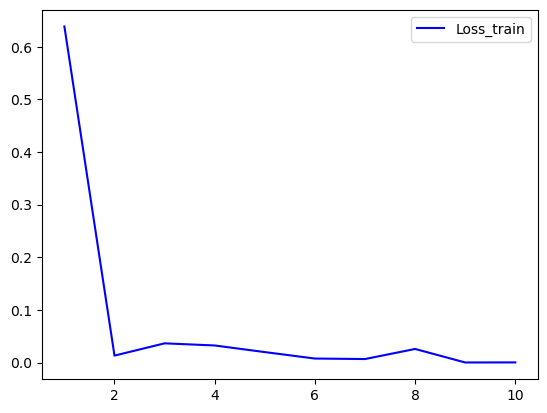

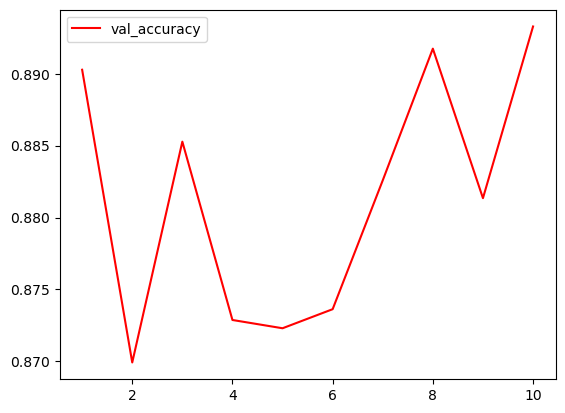

In [32]:
plt.figure()
X=[i for i in range(1,11)]
nLoss= [Loss[i].item() for i in range(len(Loss))]

plt.plot(X,nLoss, label= "Loss_train", color="blue")

plt.legend()
plt.show()


plt.figure()
nval_acc= [val_acc[i].item() for i in range(len(val_acc))]
plt.plot(X,nval_acc, label= "val_accuracy", color = "red")
plt.legend()
plt.show()


In [33]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall
from tqdm import tqdm  

model.eval()

acc = MulticlassAccuracy(num_classes=8).to(device)
precision = MulticlassPrecision(num_classes=8).to(device)


with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Test Batches"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        acc.update(preds, labels)
        precision.update(preds, labels)

test_acc = acc.compute()
test_precision = precision.compute()

print(f"Test accuracy: {test_acc:.4f}")
print(f"Test precision: {test_precision:.4f}")


Test Batches: 100%|██████████| 27/27 [00:49<00:00,  1.83s/it]

Test accuracy: 0.9205
Test precision: 0.9235


Test Batches: 100%|██████████| 27/27 [00:51<00:00,  1.90s/it]


IndexError: index 63 is out of bounds for dimension 0 with size 63

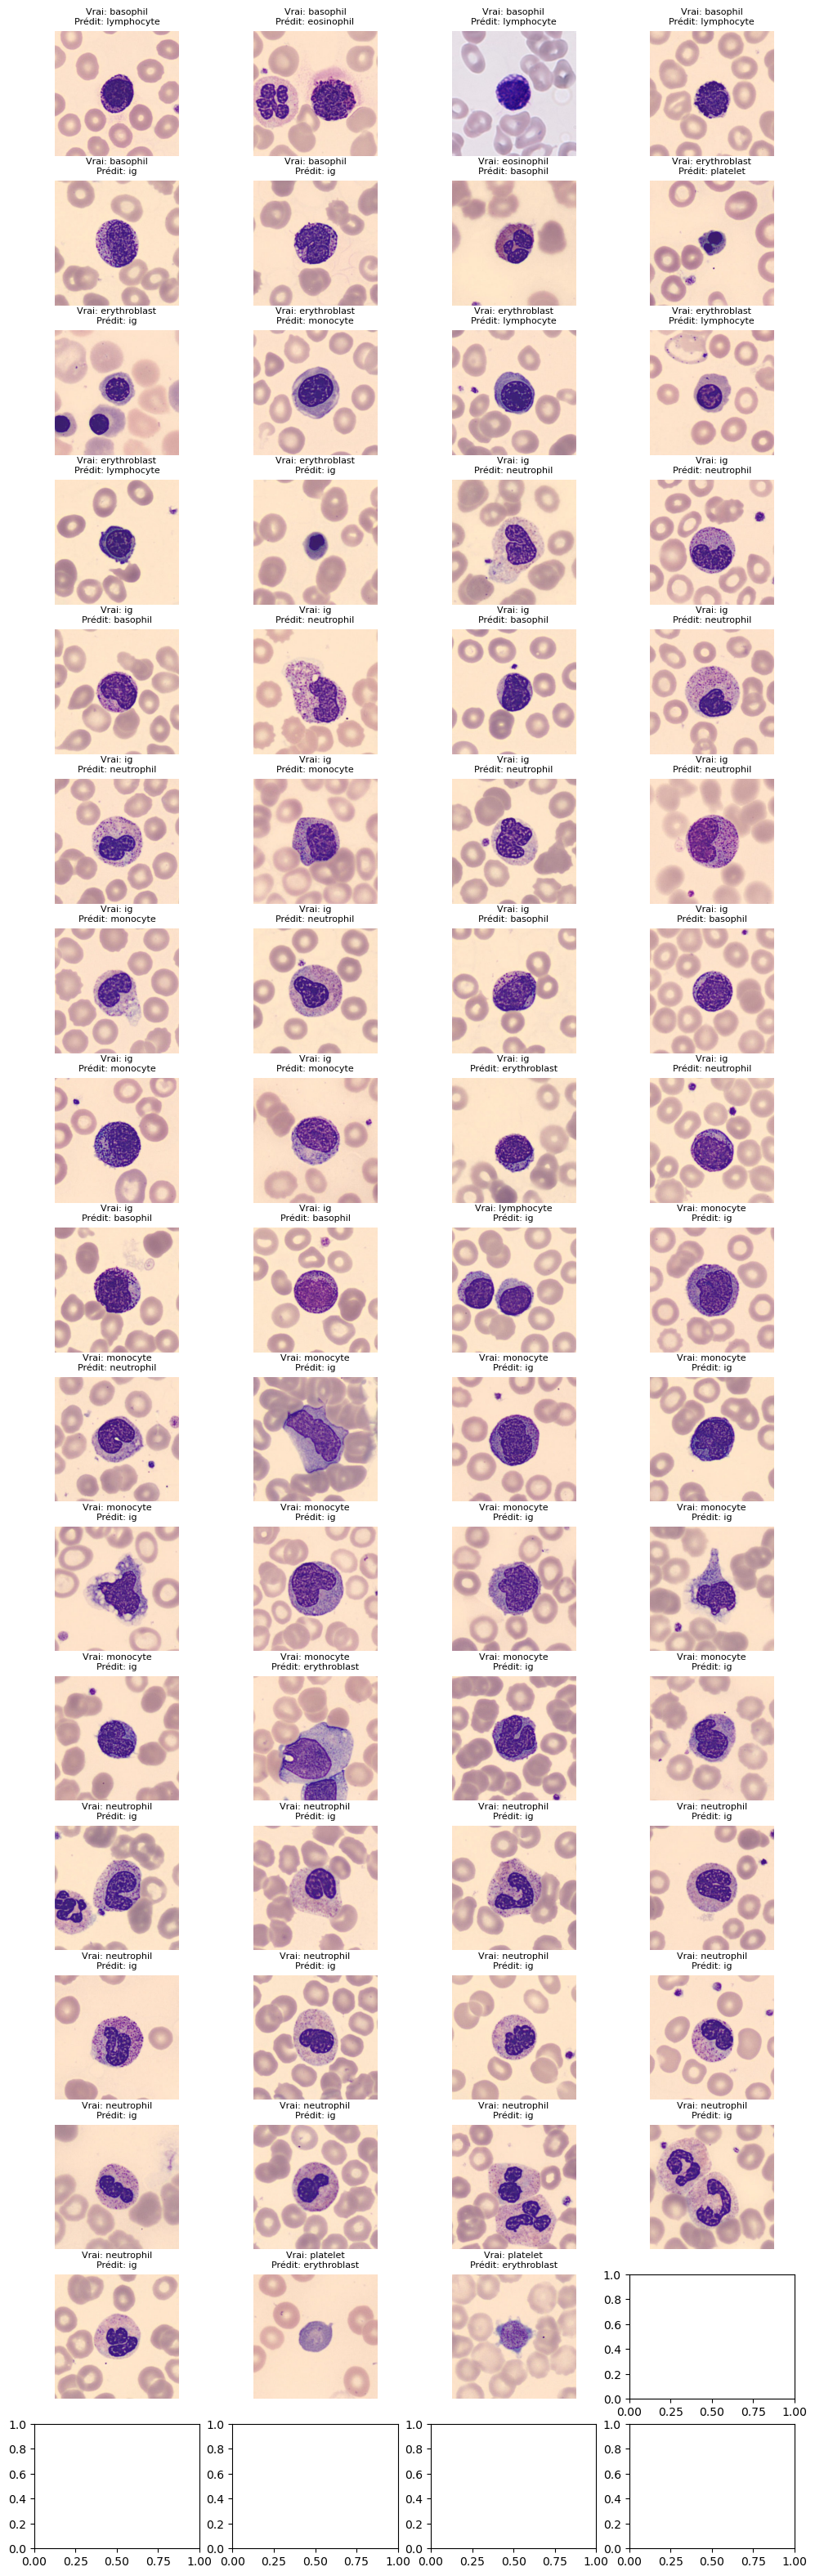

In [34]:
import matplotlib.pyplot as plt

def show_predictions(model, dataloader, class_names, device="cuda"):
    model.eval()
    model.to(device)

    error_images = []
    error_labels = []
    error_preds = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Test Batches"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            incorrect = preds != labels
            if incorrect.any():
                error_images.append(images[incorrect])
                error_labels.append(labels[incorrect])
                error_preds.append(preds[incorrect])

    images = torch.cat(error_images)
    labels = torch.cat(error_labels)
    preds = torch.cat(error_preds)


    fig, axes = plt.subplots(17, 4, figsize=(12, 40))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        
        img = images[i].cpu().permute(1, 2, 0) * torch.tensor(data_module.std) + torch.tensor(data_module.mean)
        img = img.clamp(0, 1)  # Corrige les couleurs après normalisation
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"Vrai: {true_label}\nPrédit: {pred_label}", fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Exemple d’utilisation :
show_predictions(model, data_module.test_dataloader(), data_module.train_ds.classes)





100%|██████████| 27/27 [01:10<00:00,  2.60s/it]


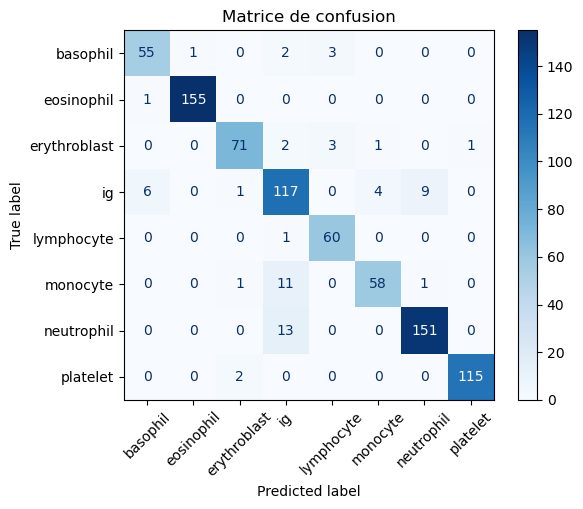

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def compute_confusion_matrix(model, dataloader, class_names, device="cuda"):
    all_preds = []
    all_labels = []

    model.eval()
    model.to(device)
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Matrice de confusion")
    plt.show()


# utiliser tensorboard
# Exemple d’appel
compute_confusion_matrix(model, data_module.test_dataloader(), data_module.train_ds.classes)


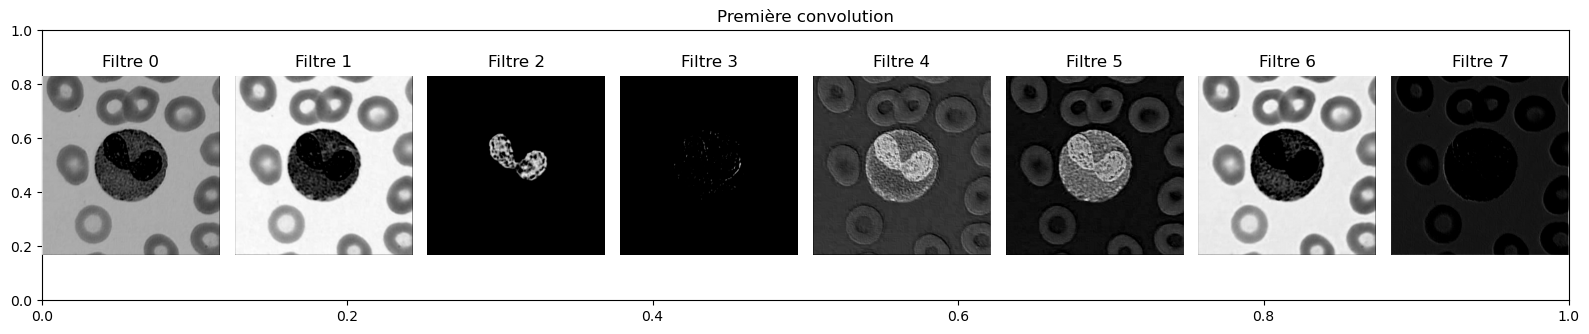

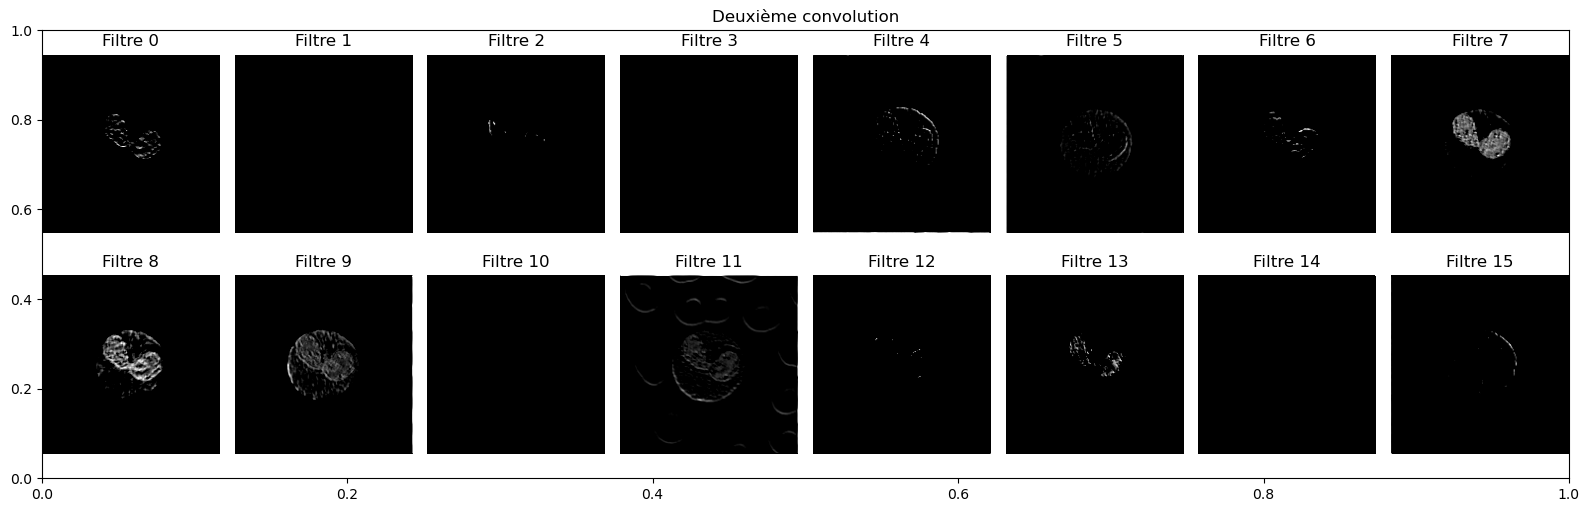

[-32.117847   -4.7924967  -9.912429   -1.9483515 -40.27903   -18.904152
   7.518343   10.22259  ]


In [95]:
import math
import matplotlib.pyplot as plt

img_path = './barcelona/barcelona/test/eosinophil/eo_33913.jpg'
img = Image.open(img_path).convert('RGB')  


transform = transforms.Compose([
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])
img_tensor = transform(img).unsqueeze(0)  

with torch.no_grad():
    model.eval()
    img_tensor = img_tensor.to(next(model.parameters()).device)  
    features1 = F.relu(model.conv1(img_tensor) )
    features2 = model.pool(features1)
    features3 = F.relu(model.conv2(features2) )
    features4 = model.pool(features3)
    features5 = features4.reshape(features4.shape[0], -1)
    features6 = model.fc1(features5)

import math
import matplotlib.pyplot as plt

n_maps1 = features1.shape[1]
cols = 8
rows = math.ceil(n_maps1 / cols)

plt.figure(figsize=(cols * 2, rows * 2+1))
plt.title('Première convolution')
for i in range(n_maps1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(features1[0, i].cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Filtre {i}')
plt.tight_layout()
plt.show()



n_maps3 = features3.shape[1]
cols = 8
rows3 = math.ceil(n_maps3 / cols)

plt.figure(figsize=(cols * 2, rows3 * 2+1))
plt.title('Deuxième convolution')
for i in range(n_maps3):
    plt.subplot(rows3, cols, i + 1)
    plt.imshow(features3[0, i].cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Filtre {i}')
plt.tight_layout()
plt.show()

n_maps4 = features6.shape[1]
cols = 8
rows4 = math.ceil(n_maps4 / cols)

print(features6[0].cpu().numpy())


## II - Modèle pré entraîné resNet

In [6]:
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
from datasets import BarcelonaDataModule, BarcelonaDataset
import matplotlib.pyplot as plt
# Définir les transformations (resize, normalisation...)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Charger les images
data_dir = 'barcelona/barcelona'
datamodule = BarcelonaDataModule(root=data_dir, batch_size=32, num_workers=0)
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'test']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=0)
    for x in ['train', 'test']
}

class_names = image_datasets['train'].classes
num_classes = len(class_names)

In [7]:
model = models.resnet50(pretrained=True)

# Remplacer la dernière couche fully connected
import torch.nn as nn
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [8]:
import torch.optim as optim
import time

device = torch.device("cuda" if torch.cuda.is_available() else"cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [9]:
from tqdm import tqdm  
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(dataloaders[phase]):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])
        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

Epoch 1/5


100%|██████████| 452/452 [09:10<00:00,  1.22s/it]


train Loss: 0.1674 Acc: 0.9501


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


test Loss: 0.0650 Acc: 0.9775
Epoch 2/5


100%|██████████| 452/452 [09:11<00:00,  1.22s/it]


train Loss: 0.0612 Acc: 0.9804


100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


test Loss: 0.0773 Acc: 0.9834
Epoch 3/5


100%|██████████| 452/452 [04:03<00:00,  1.86it/s]


train Loss: 0.0483 Acc: 0.9850


100%|██████████| 27/27 [00:07<00:00,  3.53it/s]


test Loss: 0.0639 Acc: 0.9834
Epoch 4/5


100%|██████████| 452/452 [04:04<00:00,  1.85it/s]


train Loss: 0.0313 Acc: 0.9903


100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


test Loss: 0.0668 Acc: 0.9763
Epoch 5/5


100%|██████████| 452/452 [03:38<00:00,  2.07it/s]


train Loss: 0.0271 Acc: 0.9913


100%|██████████| 27/27 [00:07<00:00,  3.58it/s]

test Loss: 0.0758 Acc: 0.9787


In [12]:
torch.save(model.state_dict(), "resnet_model_weights.pth")

100%|██████████| 27/27 [00:07<00:00,  3.81it/s]


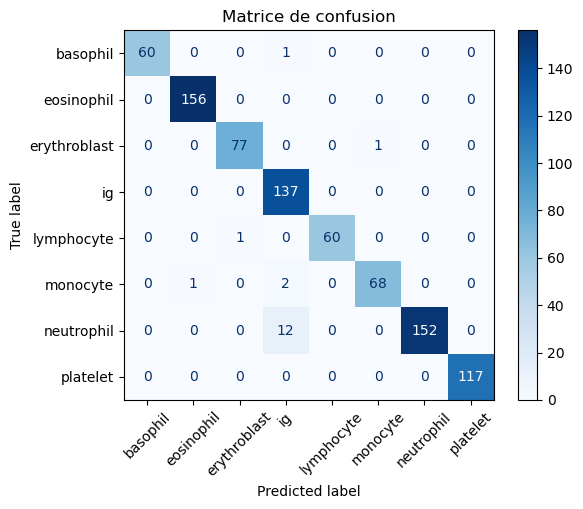

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def compute_confusion_matrix(model, dataloader, class_names, device="cuda"):
    all_preds = []
    all_labels = []

    model.eval()
    model.to(device)
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Matrice de confusion")
    plt.show()


# utiliser tensorboard
# Exemple d’appel
compute_confusion_matrix(model, dataloaders['test'], image_datasets['test'].classes)

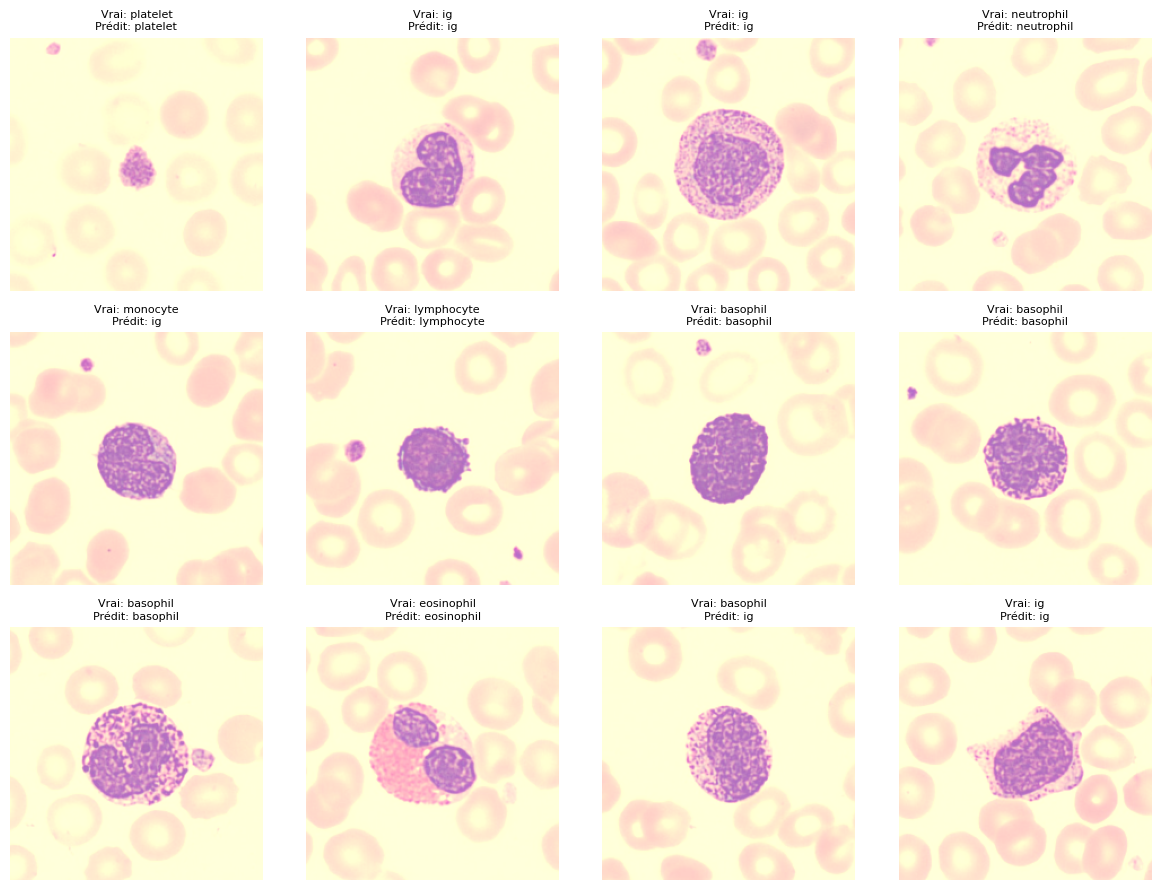

In [14]:
import matplotlib.pyplot as plt

def show_predictions(model, dataloader, class_names, device="cuda"):
    model.eval()
    model.to(device)

    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1)

    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        img = images[i].cpu().permute(1, 2, 0) * torch.tensor(datamodule.std) + torch.tensor(datamodule.mean)
        img = img.clamp(0, 1)  # Corrige les couleurs après normalisation
        ax.imshow(img)
        ax.axis("off")
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        ax.set_title(f"Vrai: {true_label}\nPrédit: {pred_label}", fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Exemple d’utilisation :
show_predictions(model, dataloaders['test'],image_datasets['test'].classes)

## III - Modèle pré entraîné alex Net

In [36]:
from datasets import BarcelonaDataModule, BarcelonaDataset

from __future__ import print_function
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import lightning as L

from sklearn.metrics import confusion_matrix, accuracy_score
from PIL import Image
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchvision.transforms as transforms
import torchvision.models as models


In [37]:
data = BarcelonaDataModule(root = './data', num_workers=0)

data.setup()
data_train = data.train_dataloader()


data_test = data.test_dataloader()
data_val = data.val_dataloader()

alexnet = models.AlexNet()
from torchvision.models import alexnet, AlexNet_Weights


In [38]:
class GlobuleClassifierAlex(pl.LightningModule):
    def __init__(self, num_classes=8):
        super().__init__()
        self.test_preds = []
        self.test_targets=[]
        self.save_hyperparameters()
        self.num_classes = num_classes


        # Charger AlexNet pré-entraîné
        weights = AlexNet_Weights.DEFAULT
        self.model = alexnet(weights=weights)

        # Geler les couches convolutionnelles
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Remplacer la dernière couche fully connected pour 8 classes
        self.model.classifier[1] = nn.Linear(9216, 271)
        self.model.classifier[4] = nn.Linear(271,271)
        """in_features = self.model.classifier[6].in_features"""
        self.model.classifier[6] = nn.Linear(271, num_classes)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.classifier.parameters(), lr=1e-3)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)

        self.test_preds.append(preds.cpu())
        self.test_targets.append(y.cpu())

        return {"loss": F.cross_entropy(logits, y)}

    def on_test_epoch_end(self):
        preds = torch.cat(self.test_preds)
        targets = torch.cat(self.test_targets)

        # Calcul accuracy
        acc = accuracy_score(targets, preds)
        self.log("test_accuracy", acc)

        # Matrice de confusion
        cm = confusion_matrix(targets, preds, labels=range(self.num_classes))
        self.conf_matrix = cm
        self.test_acc = acc  # stocker l'accuracy aussi

model = GlobuleClassifierAlex(num_classes=8)

trainer = pl.Trainer(
        max_epochs=5,
        accelerator="gpu",
        devices=1,  # ou "auto" si tu veux laisser Lightning choisir
        num_sanity_val_steps=0,
        enable_checkpointing=False,
        log_every_n_steps=1,
    )

print(trainer)
    

trainer.fit(model, train_dataloaders=data_train, val_dataloaders=data_val)

        
        
        
        

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | AlexNet          | 5.0 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
2.6 M     Trainable params
2.5 M     Non-trainable params
5.0 M     Total params
20.174    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9254437685012817
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


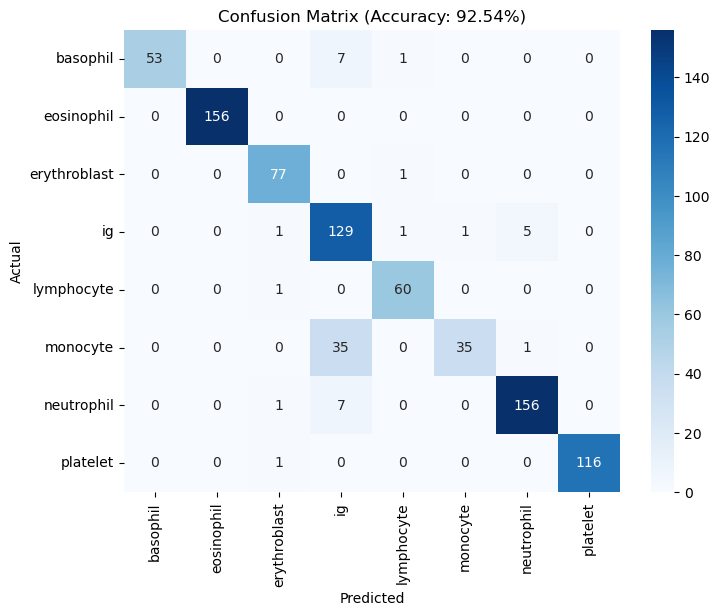

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lancer le test
trainer.test(model, data_test)


# Récupérer et afficher
conf_matrix = model.conf_matrix
acc = model.test_acc

labels = data_train.dataset.class_to_idx.keys()
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Accuracy: {acc:.2%})")
plt.show()

## IV - Modèle pré entraîné VGG

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl
from torchvision import models
from datasets import BarcelonaDataModule


class VGG16TransferLearning(pl.LightningModule):
    def __init__(self, num_classes, lr_phase1=1e-4, lr_phase2=1e-5, fine_tune=False):
        super().__init__()
        self.save_hyperparameters()

        self.model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        #self.model.classifier[6] = nn.Linear(4096, num_classes)
        self.model.avgpool =  nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.model.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=256, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=256, out_features=64, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=64, out_features=num_classes, bias=True)
        )

        for param in self.model.features.parameters():
            param.requires_grad = False

        if fine_tune:
            for param in self.model.features[-4:].parameters():
                param.requires_grad = True

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_acc", acc, on_epoch=True)

    def configure_optimizers(self):
        lr = self.hparams.lr_phase2 if self.hparams.fine_tune else self.hparams.lr_phase1
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=lr)
        # [p for p in self.parameters() if p.requires_grad]
        return optimizer

In [4]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

# Chargement des données
data_module = BarcelonaDataModule(root="barcelona", batch_size=32, num_workers=0)
data_module.prepare_data()
data_module.setup()
num_classes = len(data_module.train_ds.classes)

# Phase 1 : Transfer learning (couches gelées)
model_phase1 = VGG16TransferLearning(num_classes=num_classes, fine_tune=False)
trainer = Trainer(max_epochs=5, accelerator="gpu", devices=1)
trainer.fit(model_phase1, datamodule=data_module)

# Phase 2 : Fine-tuning (dé-gel partiel)
model_phase2 = VGG16TransferLearning(num_classes=num_classes, fine_tune=True)
model_phase2.model.load_state_dict(model_phase1.model.state_dict())  # transfert des poids
trainer = Trainer(max_epochs=5, accelerator="gpu", devices=1)
trainer.fit(model_phase2, datamodule=data_module)

# Évaluation finale
trainer.test(model_phase2, datamodule=data_module)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | VGG              | 14.9 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
148 K     Trainable params
14.7 M    Non-trainable params
14.9 M    Total params
59.452    Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | VGG              | 14.9 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
2.5 M     Trainable params
12.4 M    Non-trainable params
14.9 M    Total params
59.452    Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=79` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.942011833190918
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.942011833190918}]

In [5]:
# Sauvegarde après l'entraînement Phase 1
trainer.save_checkpoint("model_phase1.ckpt")

# Sauvegarde après l'entraînement Phase 2
trainer.save_checkpoint("model_phase2.ckpt")


In [13]:
# Charger model_phase1
model_phase1 = VGG16TransferLearning.load_from_checkpoint("model_phase1.ckpt")

# Charger model_phase2
model_phase2 = VGG16TransferLearning.load_from_checkpoint("model_phase2.ckpt")


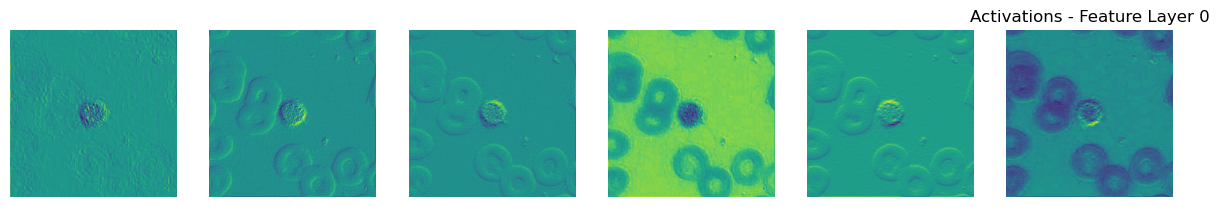

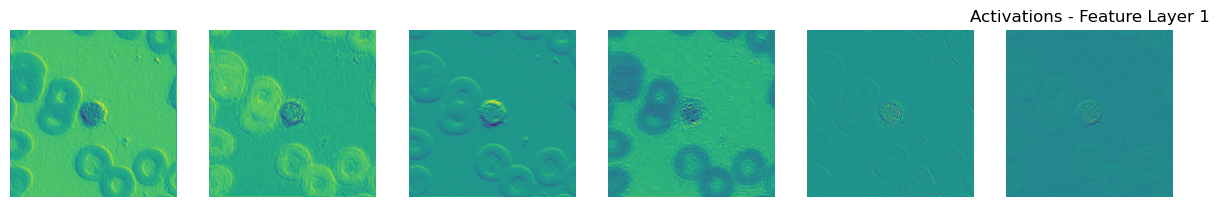

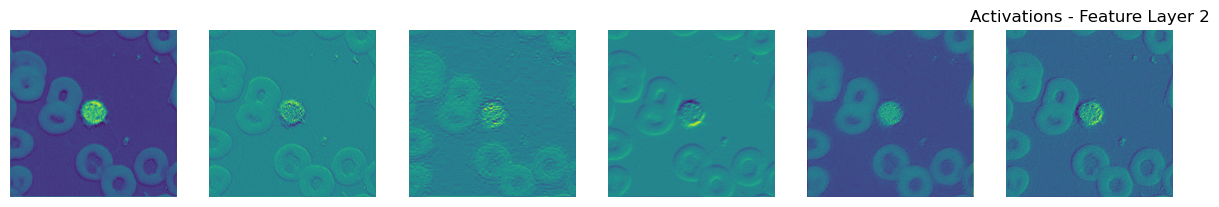

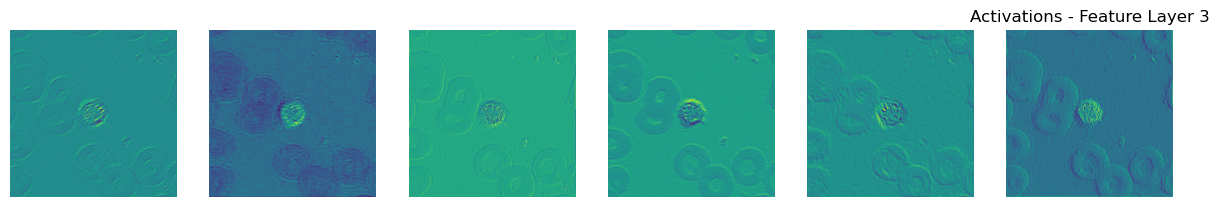

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random as rd

# Obtenir une image aléatoire depuis le dataset de validation
img, label = rd.choice(data_module.val_ds)
input_img = img.unsqueeze(0).to(model_phase1.device)  # batchify + envoyer sur le GPU

# Récupérer les 5 premières couches
mod = list(model_phase2.model.features.children())
layers = [mod[0], mod[2], mod[5], mod[7]]

# Stocker les activations
activations = []
x = input_img
for layer in layers:
    x = layer(x)
    activations.append(x)

# Fonction d'affichage des cartes d'activation
def show_feature_maps(feature_tensor, title, num_maps=6):
    feature_tensor = feature_tensor.squeeze(0).detach().cpu()
    num_maps = min(num_maps, feature_tensor.shape[0])
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 5))
    for i in range(num_maps):
        axes[i].imshow(feature_tensor[i])
        axes[i].axis('off')
    plt.title(title)
    plt.show()

# Afficher les activations
for i, act in enumerate(activations):
    show_feature_maps(act, title=f'Activations - Feature Layer {i}', num_maps=6)


In [3]:
model_phase2

VGG16TransferLearning(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.650465961792861e-08..1.000000028269751].


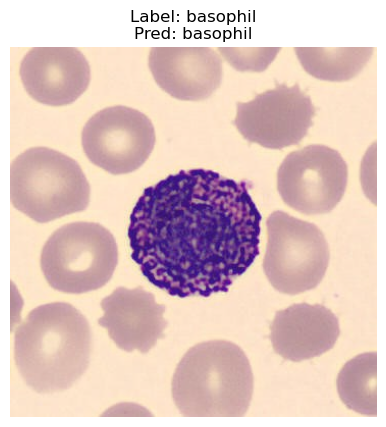

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.003921586722431147..1.000000028269751].


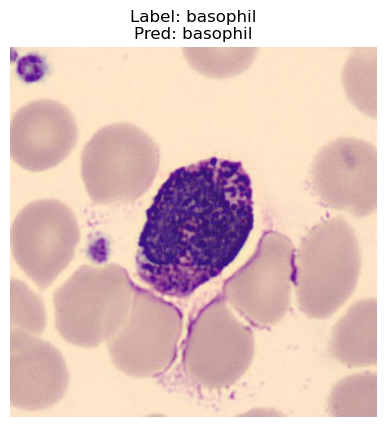

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.650465961792861e-08..1.000000028269751].


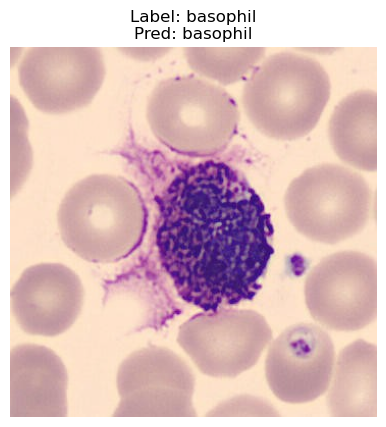

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.650465961792861e-08..1.000000028269751].


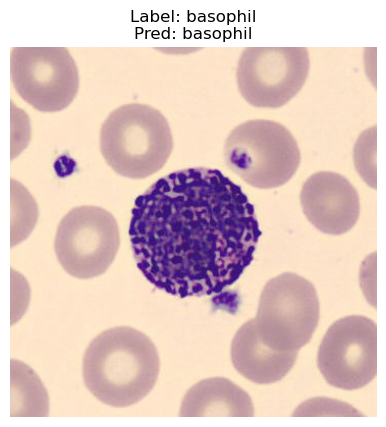

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.650465961792861e-08..1.000000028269751].


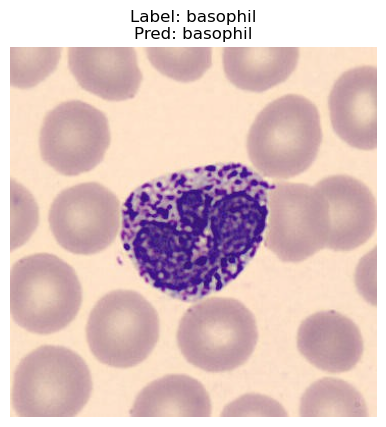

In [14]:
import matplotlib.pyplot as plt

classes = data_module.train_ds.classes

test_loader = data_module.test_dataloader()

def show_predictions(model, loader, n=5, device="cpu"):
    model.eval()
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images[:n].to(device)
    labels = labels[:n].to(device)

    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    for i in range(n):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * data_module.std + data_module.mean  # unnormalize
        plt.imshow(img)
        plt.title(f"Label: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
        plt.axis('off')
        plt.show()

show_predictions(model_phase2, test_loader)


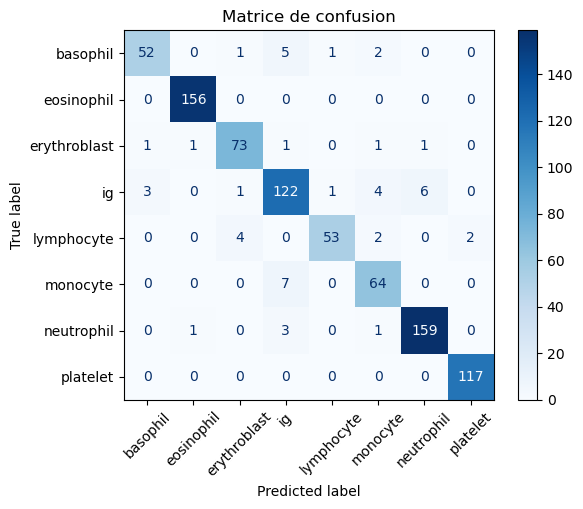

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def compute_confusion_matrix(model, dataloader, class_names, device="cpu"):
    all_preds = []
    all_labels = []

    model.eval()
    model.to(device)
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Matrice de confusion")
    plt.show()

# Exemple d’appel
compute_confusion_matrix(model_phase2, test_loader, data_module.train_ds.classes)